Reading in all libraries

In [1]:
library("huge")

Loading required package: Matrix
Loading required package: lattice
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: MASS


Reading in Modified Data File

In [2]:
expressionData=read.csv("hg-annoHeaderCorrection.csv", header=TRUE, stringsAsFactors = FALSE)

Getting Dimensions of expressionData matrix before cleaning everything up

In [3]:
print(dim(expressionData))

[1] 16242  3229


Getting Duplicated Gene Entries

In [4]:
duplicatedGenesLogicalIndices=duplicated(expressionData$geneName)
duplicatedGeneNames= expressionData$geneName[duplicatedGenesLogicalIndices]
print("Duplicated Genes:")
print(duplicatedGeneNames)

[1] "Duplicated Genes:"
 [1] "NBPF14"       "EFNA3"        "DCAF8"        "TFDP2"        "FAM47E-STBD1"
 [6] "AQP1"         "KDM4C"        "SYT15"        "PSMA1"        "ALG9"        
[11] "SLCO1B3"      "PXMP2"        "ZNF268"       "NPIPA7"       "NPIPA7"      
[16] "CLN3"         "ACE"          "GAA"          "SLC25A10"     "TMIGD2"      
[21] "ZNF763"       "KLRD1"        "CBS"          "U2AF1"        "SUMO2"       
[26] "RBM4B"        "IDS"         


Removing the duplicated genes from the analysis. This should not affect the analysis very much.

In [5]:
expressionData=expressionData[!duplicatedGenesLogicalIndices,]
print(dim(expressionData))

[1] 16215  3229


In [6]:
#Getting Expression Values for all Genes across all single cells.
expressionValues=expressionData[,(2:ncol(expressionData))]

#Writing Genes for Later Use by the Java Program and possibly GO Term Analysis
write.table(expressionData$geneName,"geneNamesHuman.csv",quote=FALSE, row.names=FALSE, col.names=FALSE)

#Removing NA values. Hopefully this will resolve the problems with the graph. Right now I am seeing values only 
#along the diagnal. This should hopefully fix that problem.
expressionValues[is.na(expressionValues)]=0

print(dim(expressionValues))

[1] 16215  3228


Randomly sampling about 500 rows from the matrix to check what kind of sparsity I get.

In [7]:
randomRows=sample(1:nrow(expressionValues),500,replace = FALSE)
expressionValues=expressionValues[randomRows,]
print(dim(expressionValues))

[1]  500 3228


In [8]:
expressionMatrix=as.matrix(t(expressionValues))
print(dim(expressionMatrix))

[1] 3228  500


In [9]:
print("Everything except Graph model done")
#No need to do a Log transform and calculate RPM. Rizi already has done all this stuff. Moreover she used TPM

#Trying the output for a lot of lambdas. This should give me a sparcity vector in the output.
#######################################################################################################
lambdas=seq(0.01,1,by=0.01)
graphModel = huge(expressionMatrix, method="glasso", lambda=lambdas)
print("Done!")
#######################################################################################################

[1] "Everything except Graph model done"
Conducting the graphical lasso (glasso)....done.                                          
[1] "Done!"


Plotting relationship between sparsity and lambda

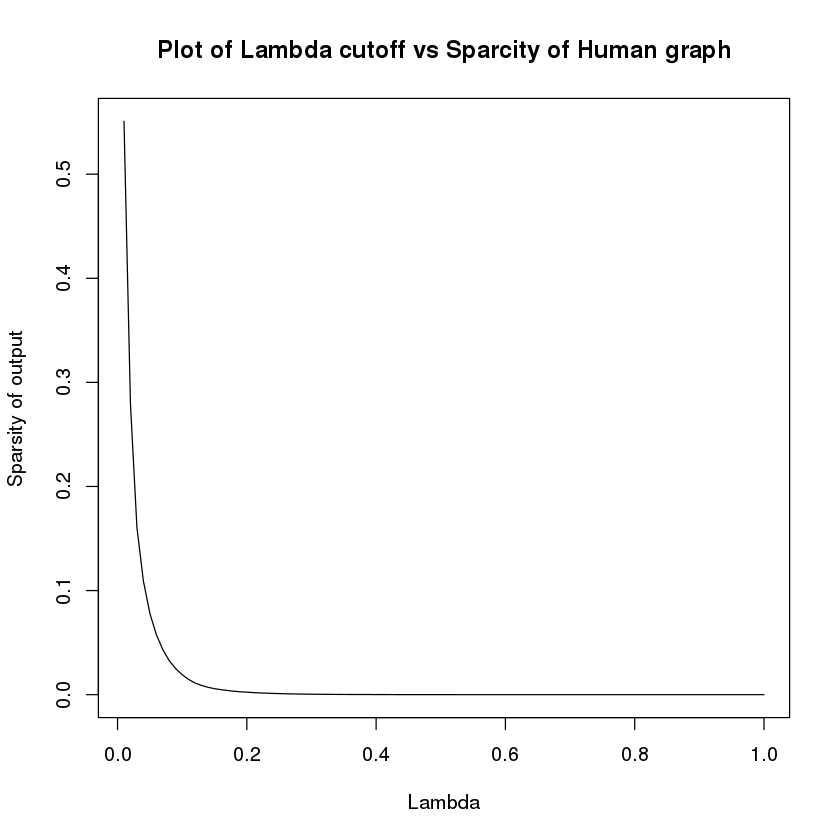

In [10]:
plot(lambdas,graphModel$sparsity,type='l',main="Plot of Lambda cutoff vs Sparcity of Human graph",xlab="Lambda", ylab = "Sparsity of output")

In [11]:
print(dim(graphModel$icov[[1]]))

[1] 500 500


Writing Sparsity and Lambda vector to an output file

In [14]:
outFileData=cbind(lambdas,graphModel$sparsity)
colnames(outFileData)=c("Lambdas","Sparsity")
head(outFileData)

Lambdas,Sparsity
0.0100000,0.5507695
0.0200000,0.2789299
0.0300000,0.1605531
0.0400000,0.1092024
0.05000000,0.07817234
0.06000000,0.05778758


Writing this output to a File

In [15]:
write.table(outFileData,"humanSparsityData.csv",quote=FALSE, row.names=FALSE, col.names=TRUE)

In [19]:
readingOutput=read.table("humanSparsityData.csv",header=TRUE)
head(readingOutput)
dim(readingOutput)

,Lambdas,Sparsity
1,0.01,0.5507695
2,0.02,0.2789299
3,0.03,0.1605531
4,0.04,0.1092024
5,0.05,0.07817234
6,0.06,0.05778758


[1] 100   2

In [20]:
readingMouseOutput=read.table("mouseSparsityData.csv",header=TRUE)
head(readingMouseOutput)
dim(readingMouseOutput)

,Lambdas,Sparsity
1,0.01,0.4856393
2,0.02,0.247984
3,0.03,0.1374669
4,0.04,0.09042485
5,0.05,0.07121443
6,0.06,0.06121844


[1] 100   2

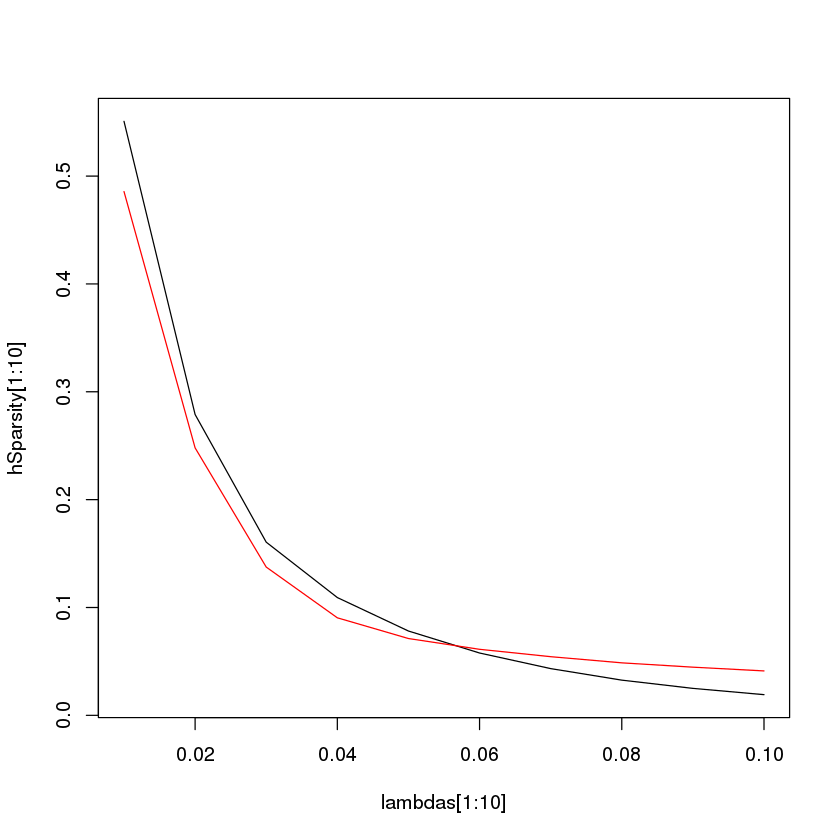

In [23]:
lambdas=readingOutput$Lambdas
hSparsity=readingOutput$Sparsity
mSparsity=readingMouseOutput$Sparsity
plot(lambdas[1:10],hSparsity[1:10],type='l')
lines(lambdas[1:10],mSparsity[1:10],type='l',col='red')

From this graph it seems like 0.055 is the best sparsity cutoff to take for both the dataset. Note this is number has been obtained from a random sample so this might not be perfect. But I think this is a good starting point.